In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
%matplotlib inline
path = './data/'

import statsmodels
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import utils

/Users/Brenton/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def fill_missing_obs(DF, StationID):
    '''This function fills missing values for a particular station
    @StationID: string format 
    @DF: dataframe
    '''
    DF['missing_'+StationID] = np.where(DF[StationID]>-99, 0, 1)
    missing = DF[DF['missing_'+StationID]==1]
    
    for x in missing.index: #For each missing cell
        if x != 0 and x != len(DF)-1:
            non_missing_prior_index = x-1 #Find most recent past record 
            non_missing_post_index = x+1  
    
            while True:
                if non_missing_prior_index in missing.index:
                    non_missing_prior_index = non_missing_prior_index - 1
                else:
                    break
        
            while True:
                if non_missing_post_index in missing.index:
                    non_missing_post_index = non_missing_post_index + 1
                else:
                    break

            pre_AQI = DF.loc[non_missing_prior_index, StationID] 
            post_AQI = DF.loc[non_missing_post_index, StationID]

            priordiff = x - non_missing_prior_index
            postdiff = non_missing_post_index - x
            diff = priordiff + postdiff
            prior_weight = postdiff/diff
            post_weight = priordiff/diff
    
            DF.loc[x, StationID] = (prior_weight*pre_AQI) + (post_weight*post_AQI) 
    
    #else if x == 0 or x == len(DF)-1
    DF[StationID] = DF[StationID].fillna(method = 'ffill').fillna(method = 'bfill')
    return DF

In [3]:
def remove_columns(DF, list_of_stations):
    '''This function removes station data that will not be used in our model.
    @list_of_stations: a list of stations that we want to keep!
    '''
    cols = ['date', 'month', 'weekday', 'hour', 'year']
    stations = [x for x in list_of_stations]
    stations_missing = ['missing_'+y for y in list_of_stations]
    cols.extend(stations)
    cols.extend(stations_missing)
    new_DF = DF[cols]
    return new_DF

def plot_ccf(x, y, ax=None, lags=None, alpha=.05, use_vlines=True, unbiased=False,
             fft=False, title='Cross-correlation', zero=True, **kwargs):
    fig, ax = utils.create_mpl_ax(ax)
    lags, nlags, irregular = statsmodels.graphics.tsaplots._prepare_data_corr_plot(x, lags, zero)
    confint = None
    ccf_val = ccf(x, y)
    if lags is not None:
        ccf_val = ccf_val[:nlags+1]
    statsmodels.graphics.tsaplots._plot_corr(ax, title, ccf_val, confint, lags, irregular, use_vlines, **kwargs)
    return fig

In [4]:
AQI = pd.read_csv('AQI.csv')
AQI = AQI.drop('Unnamed: 0', 1)

#Convert date column into a "real" date column, not a floating number
AQI['date'] = AQI['date'].astype(int).astype(str)
AQI['date'] = pd.to_datetime(AQI['date']).dt.date

#Reshuffle columns so that date, hour, type are at the front
observation_cols = list(AQI.columns.values[:-3])
cols = list(AQI.columns.values[-3:])
cols.extend(observation_cols)

AQI = AQI[cols]

Times = pd.DataFrame(pd.date_range(datetime.date(2014, 5, 13), datetime.date(2017, 1, 1), freq='H')[:-1])\
          .rename(columns={0: 'Time'})
    
Times['date'] = Times['Time'].dt.date
Times['hour'] = Times['Time'].dt.hour
Times['month'] = Times['Time'].dt.month
Times['year'] = Times['Time'].dt.year
Times['weekday'] = Times['Time'].dt.weekday
Times = Times.drop('Time',1)

AQI = AQI.merge(Times, on=['date', 'hour'], how='right')
AQI = AQI.sort_values(by=['date','hour']).reset_index(drop=True)

In [5]:
metro_codes = pd.read_csv(path+'Station_Metro_Codes.csv')
metro_codes = metro_codes.drop('Unnamed: 0', 1)
stations_to_use = list(metro_codes['StationID'])
metros_to_use = list(metro_codes['Metro'])

for s in stations_to_use:
    AQI = fill_missing_obs(AQI, s)

In [6]:
AQI_less = remove_columns(AQI, stations_to_use)

# Plot data over time for all stations 

In [7]:
AQI_less.head()

,date,month,weekday,hour,year,1589A,1012A,1342A,1434A,1419A,...,missing_1406A,missing_1310A,missing_1144A,missing_1099A,missing_1493A,missing_1330A,missing_1465A,missing_1482A,missing_1488A,missing_1316A
0,2014-05-13,5,1,0.0,2014,108.0,86.0,72.0,218.0,65.0,...,0,0,0,0,0,0,0,0,0,0
1,2014-05-13,5,1,1.0,2014,117.0,84.0,80.0,230.0,63.0,...,0,0,0,0,0,0,0,0,0,0
2,2014-05-13,5,1,2.0,2014,118.0,100.0,77.0,252.0,63.0,...,0,0,0,0,0,0,0,0,0,0
3,2014-05-13,5,1,3.0,2014,116.0,95.0,68.0,283.0,69.0,...,0,0,0,0,0,0,0,0,0,0
4,2014-05-13,5,1,4.0,2014,121.0,100.0,68.0,324.0,70.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
month_years = AQI_less.drop_duplicates(subset=['month', 'year'])
np.array(month_years.index)[1:]

array([  456,  1176,  1920,  2664,  3384,  4128,  4848,  5592,  6336,
        7008,  7752,  8472,  9216,  9936, 10680, 11424, 12144, 12888,
       13608, 14352, 15096, 15792, 16536, 17256, 18000, 18720, 19464,
       20208, 20928, 21672, 22392])

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


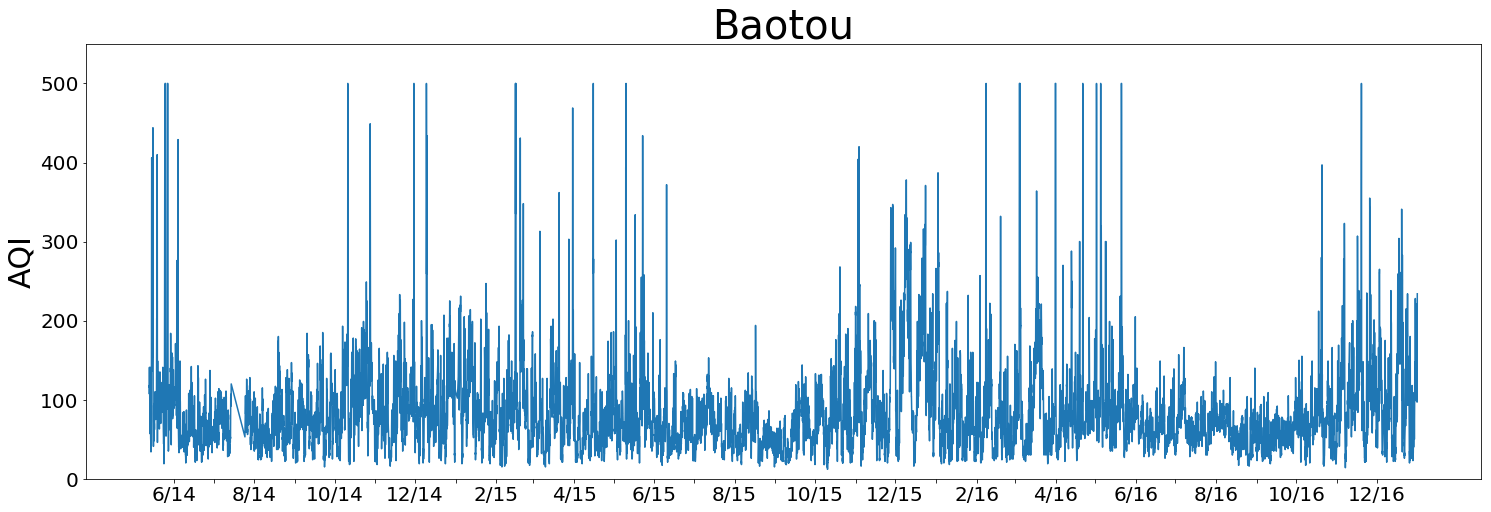

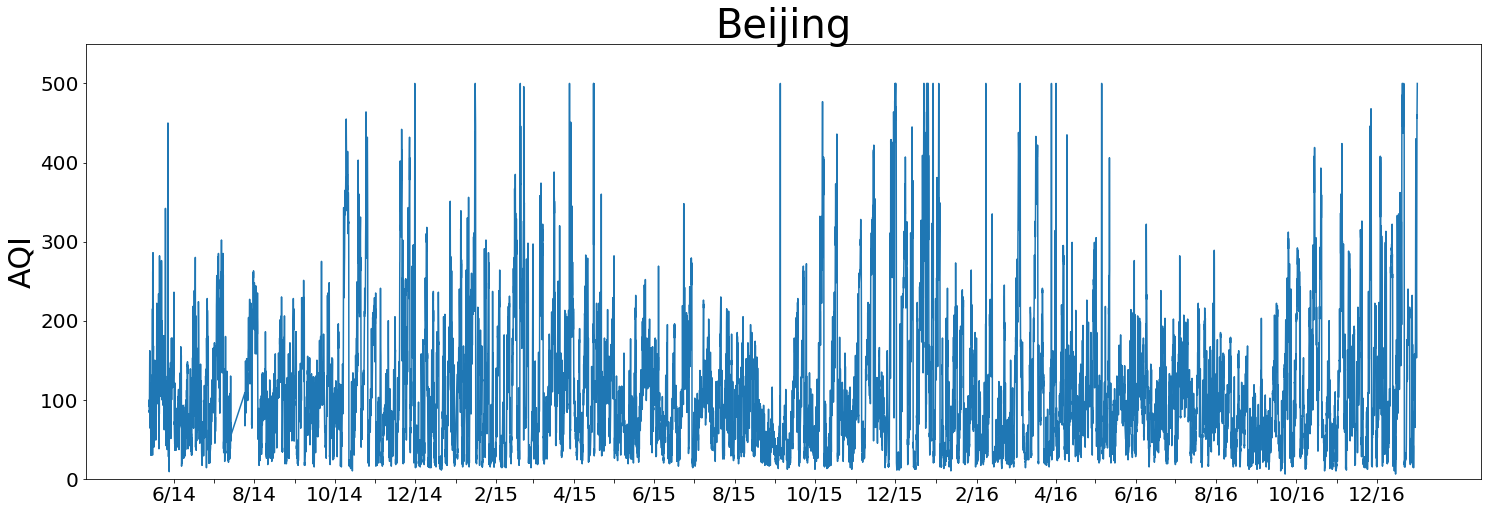

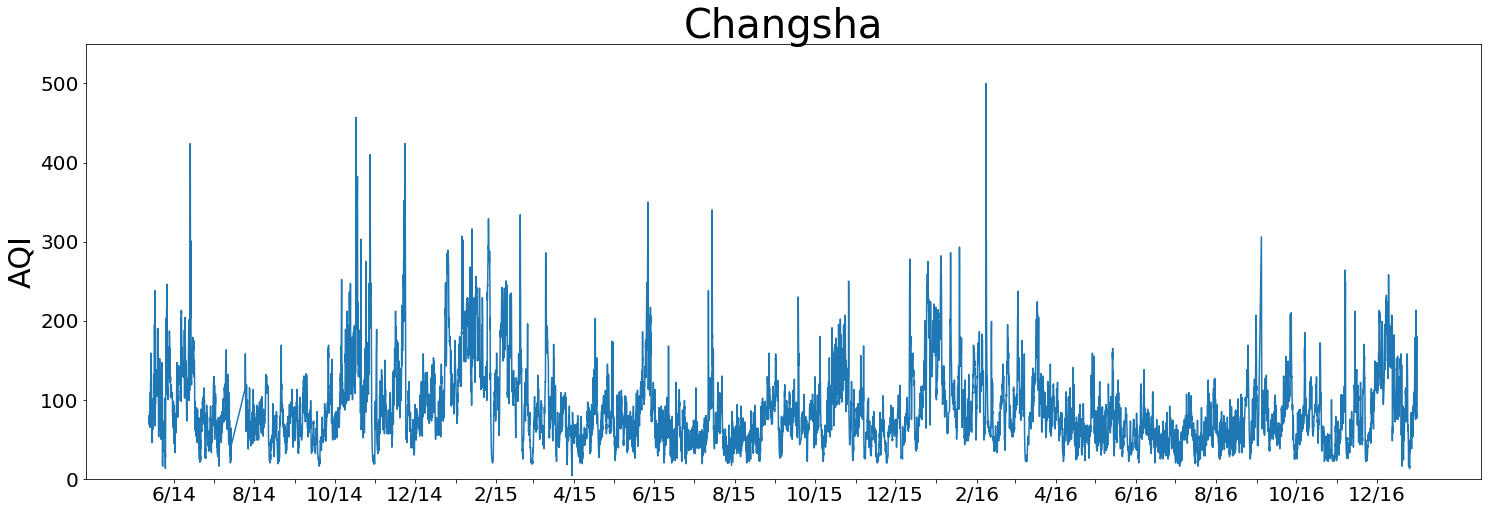

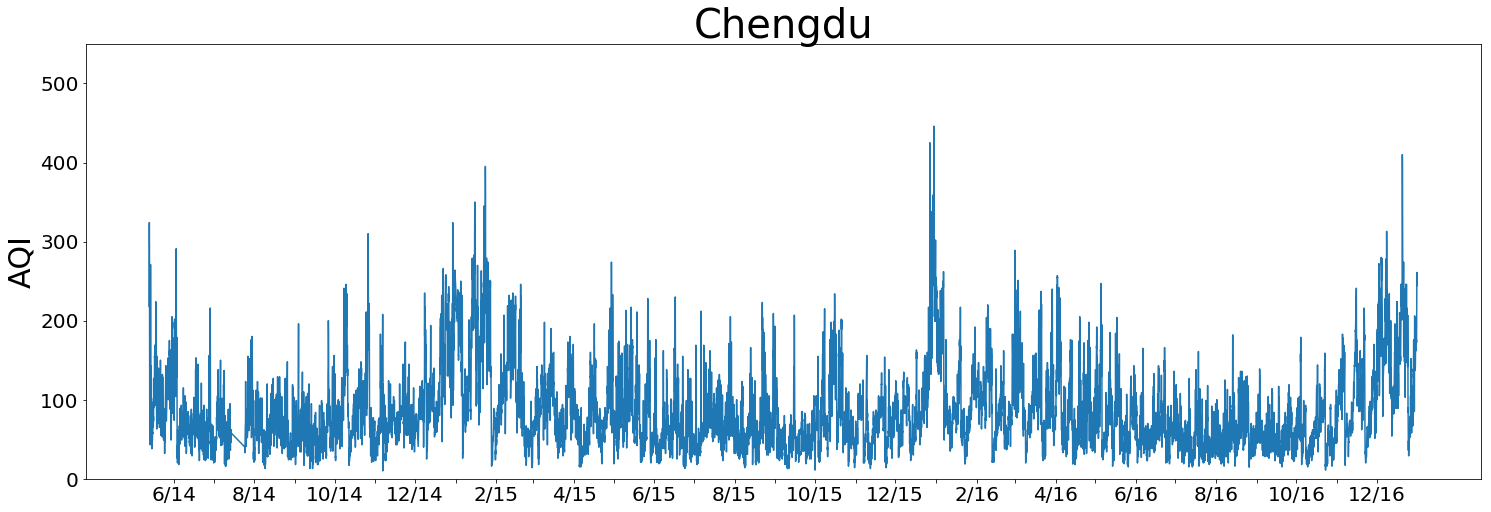

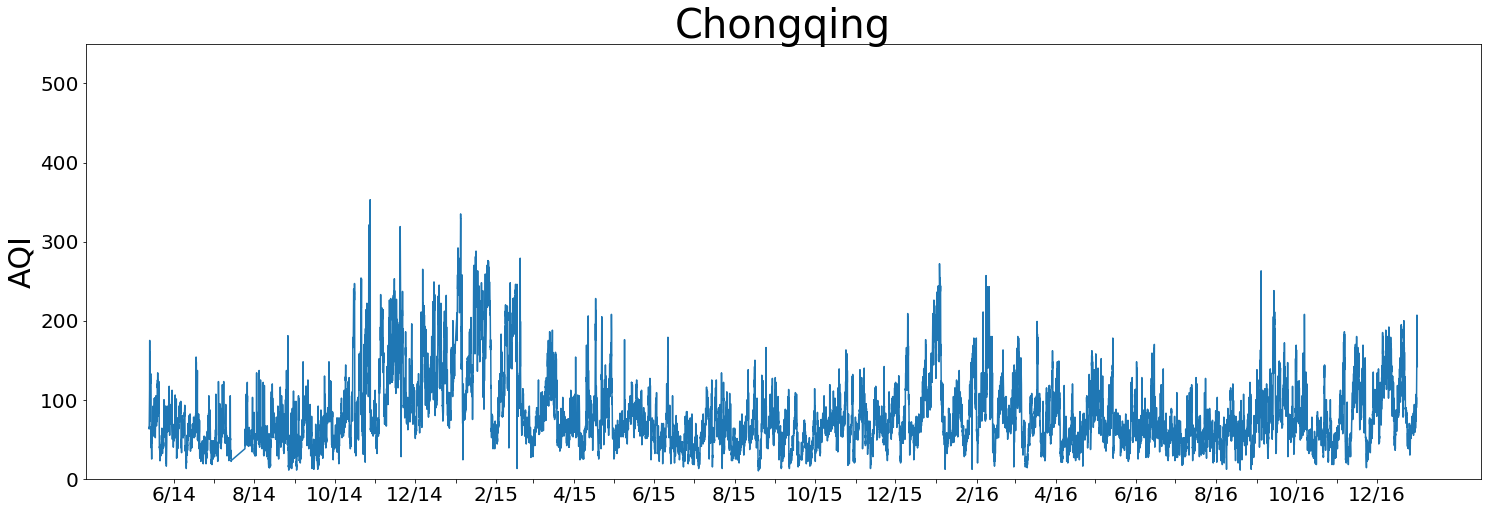

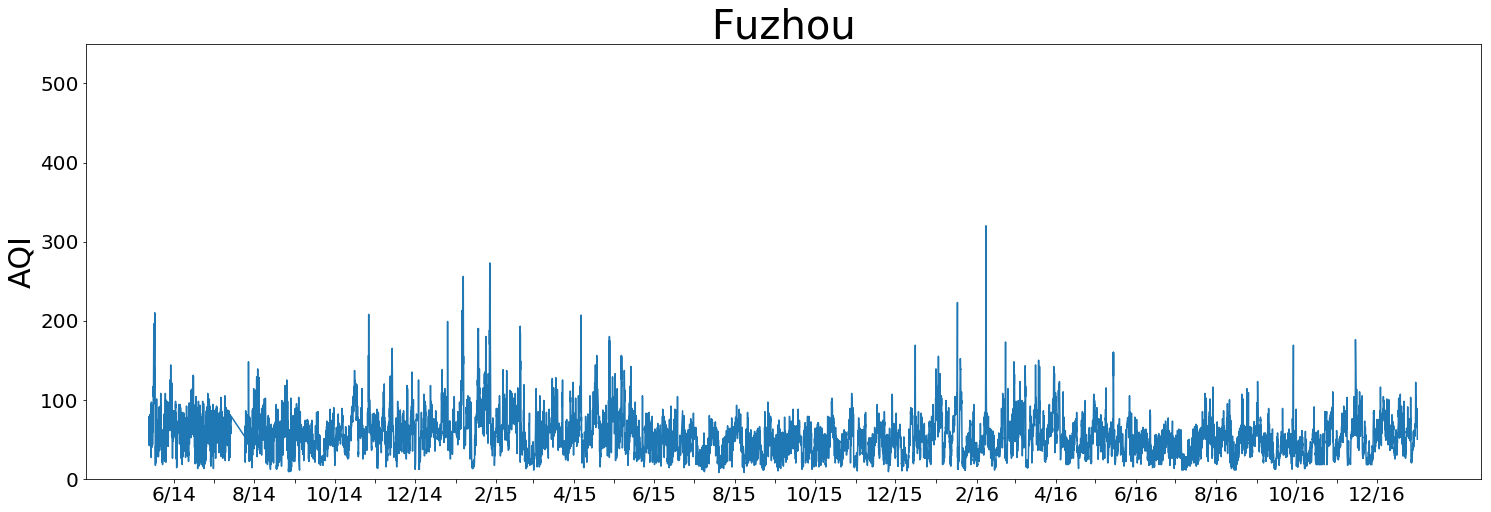

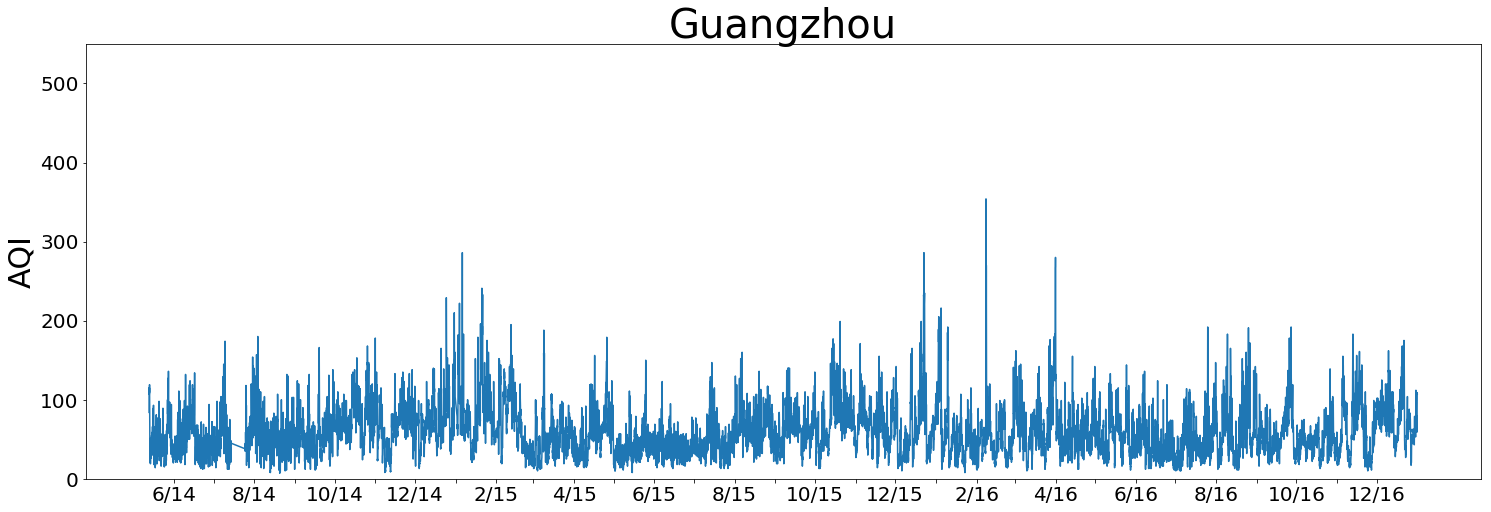

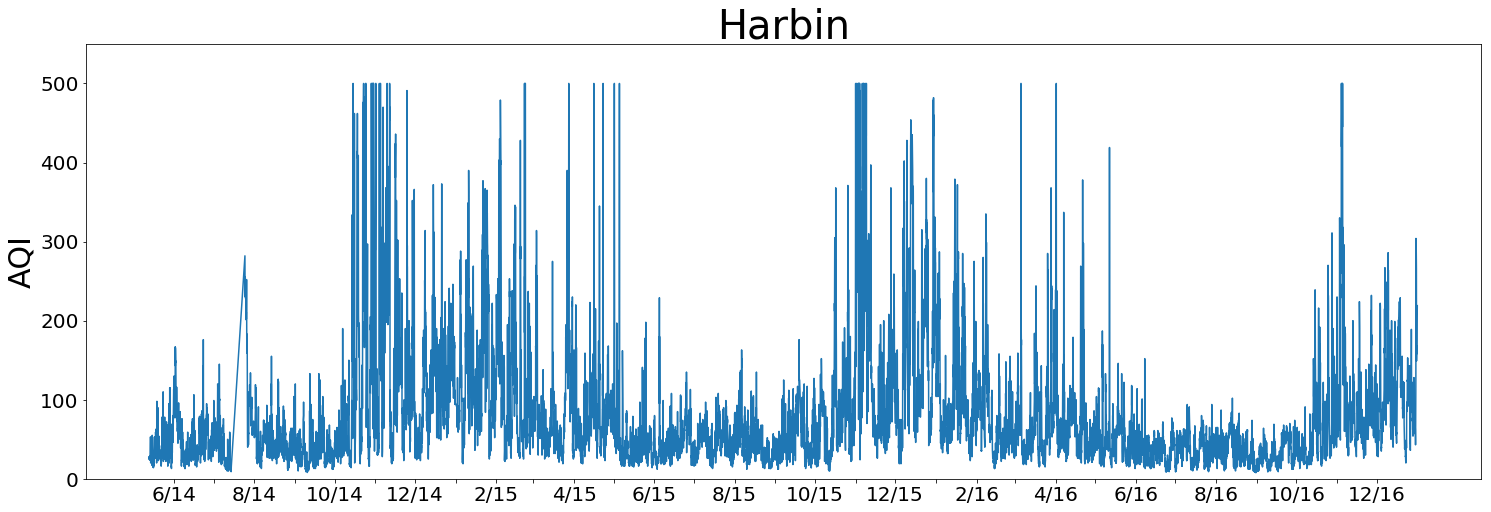

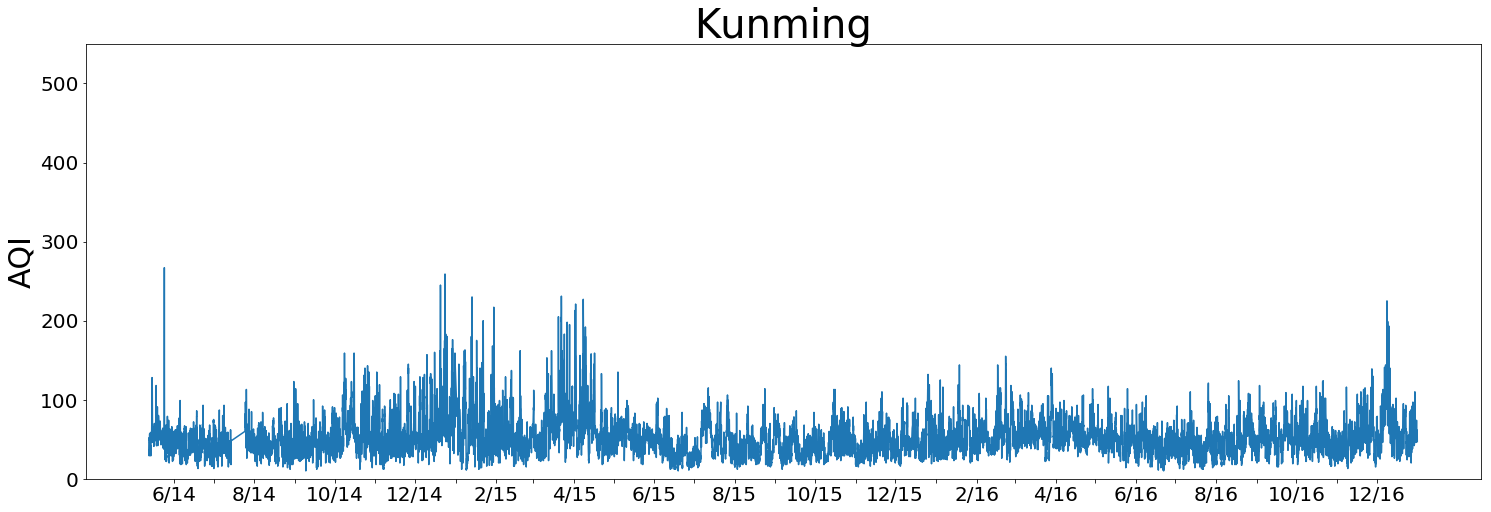

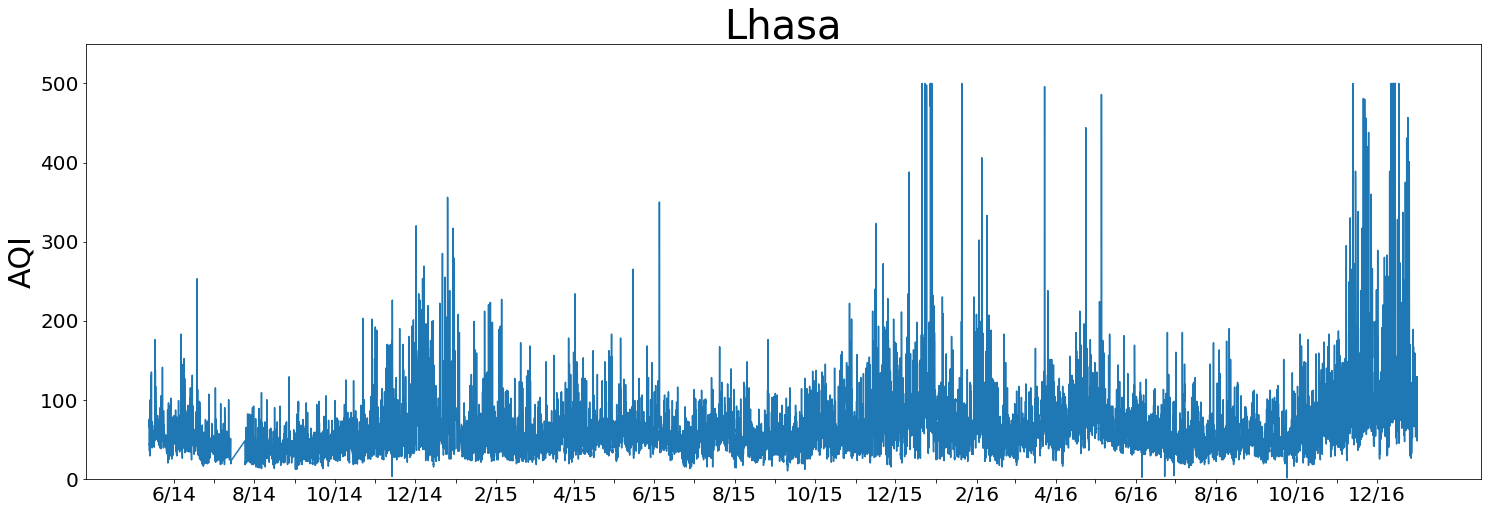

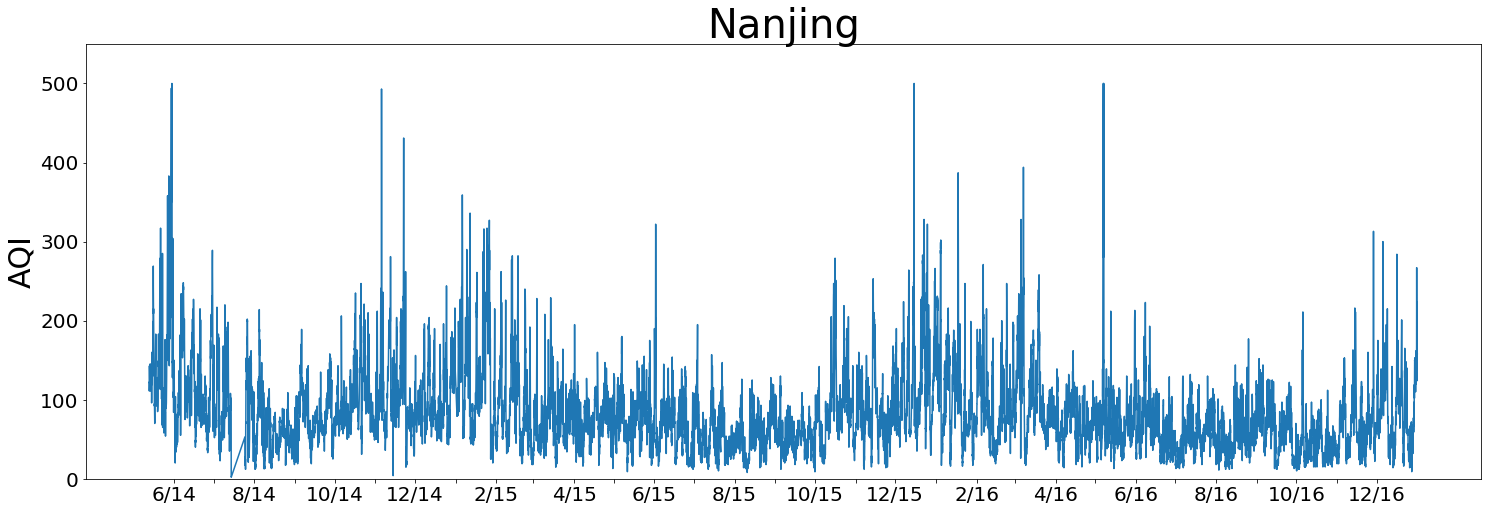

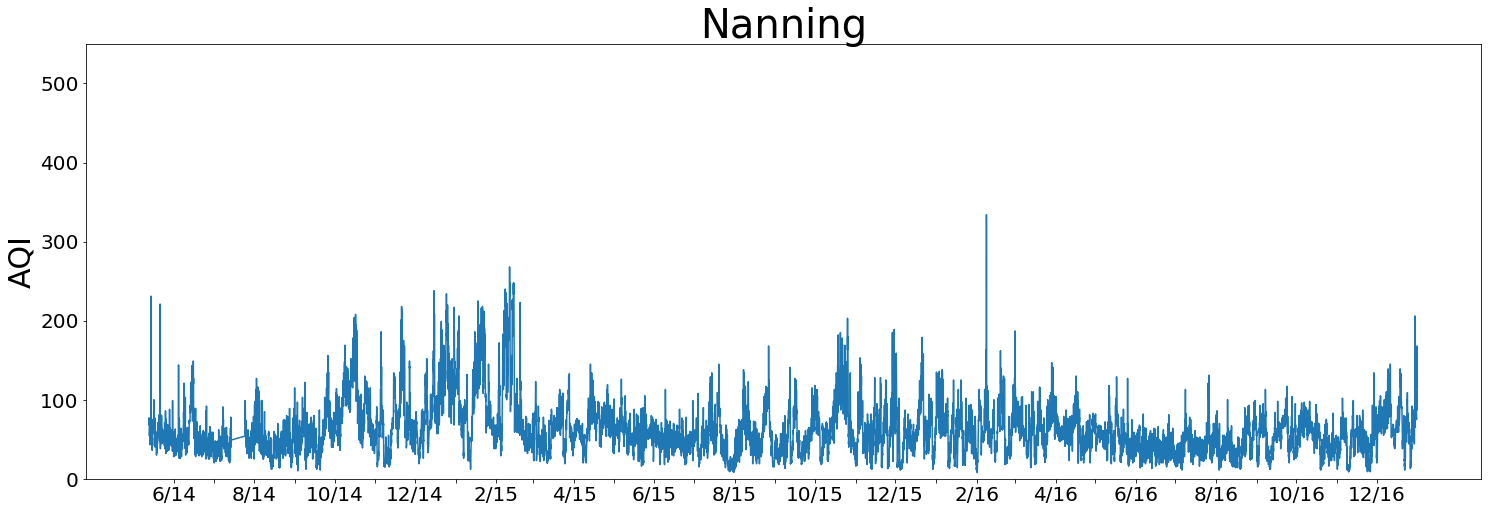

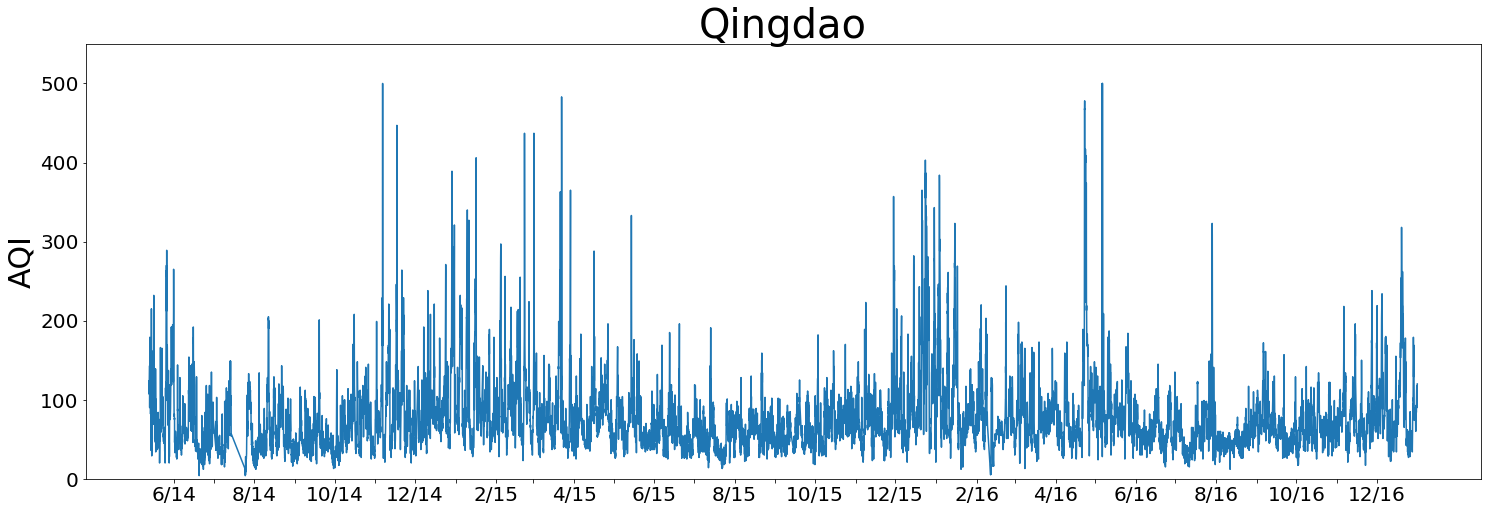

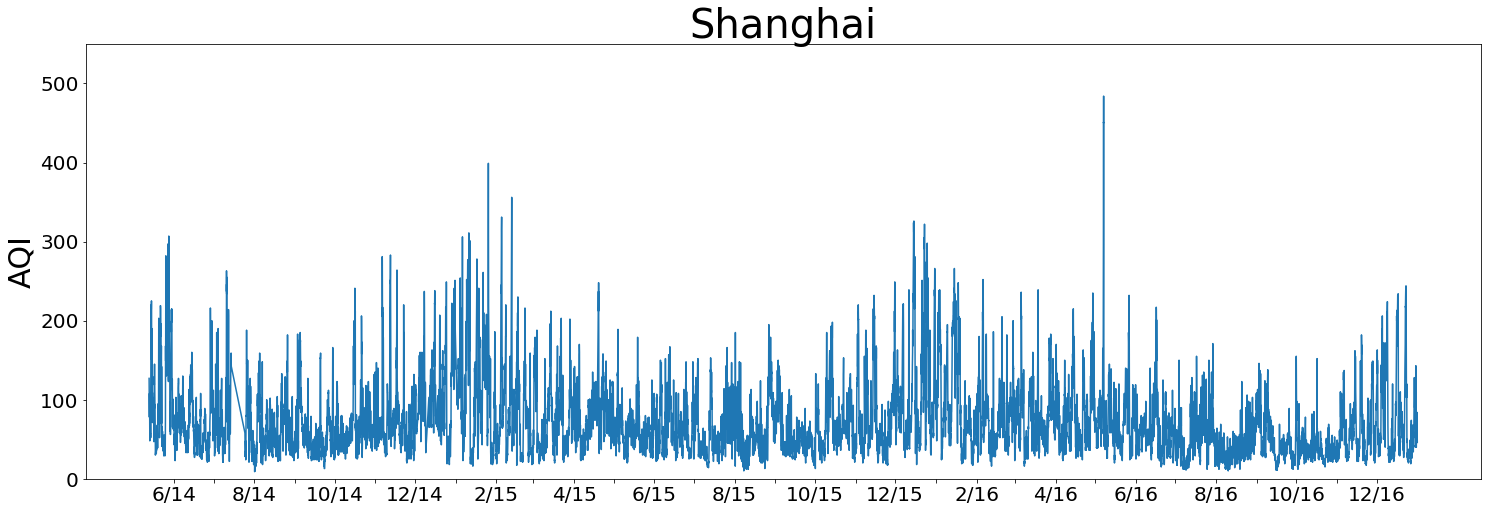

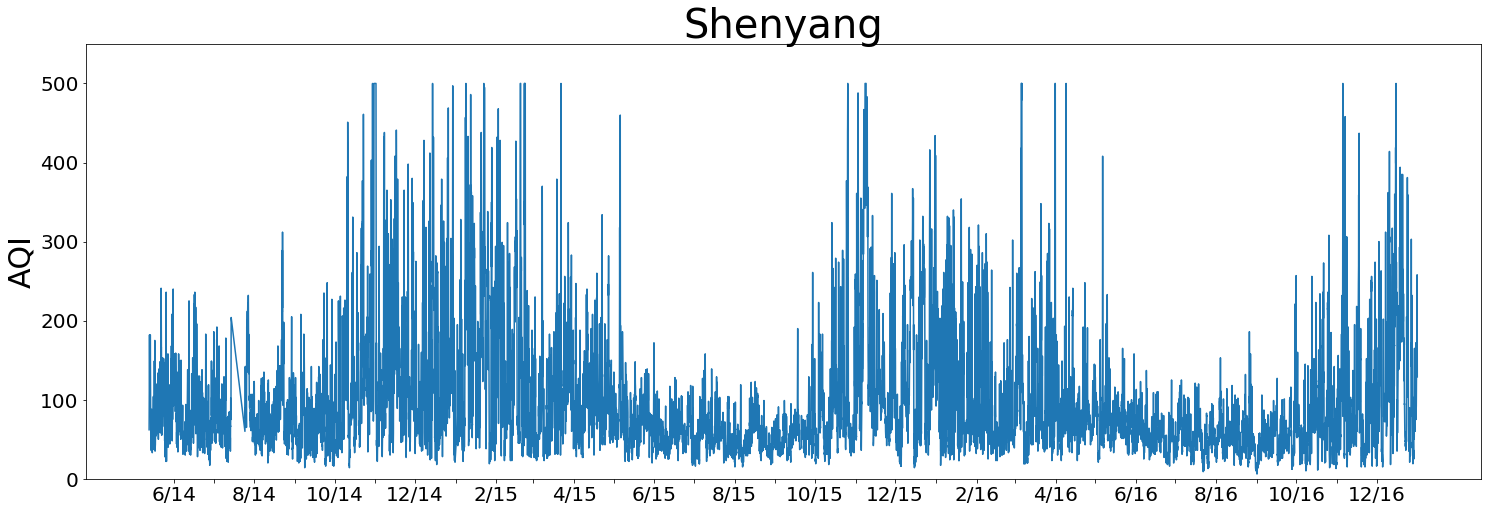

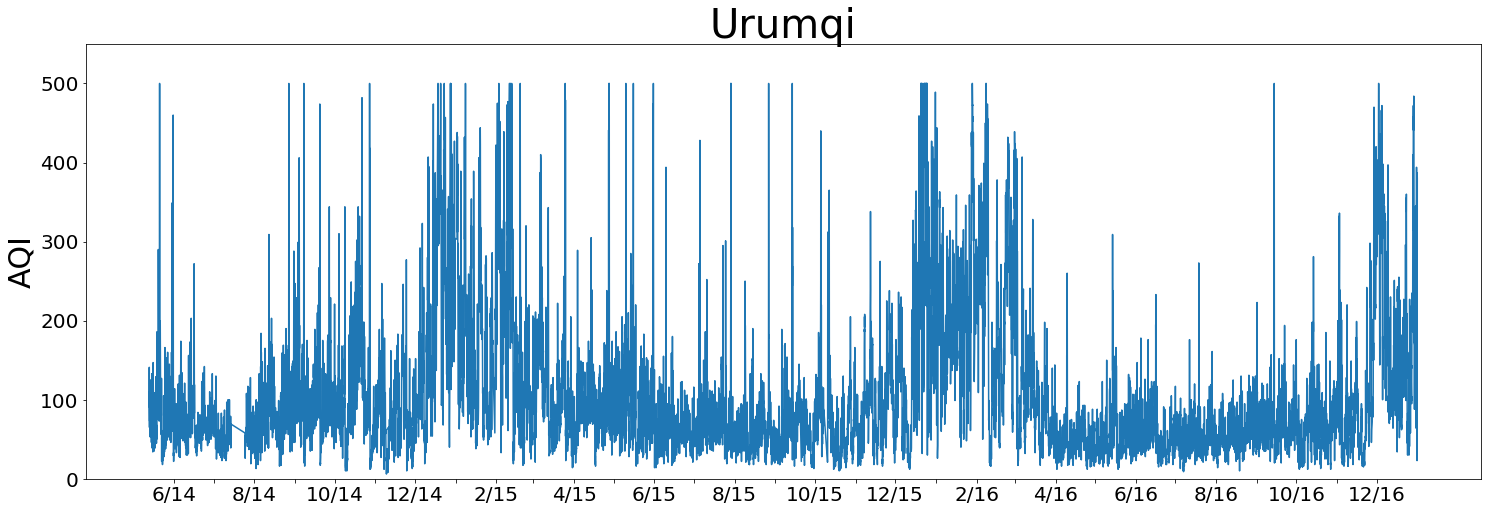

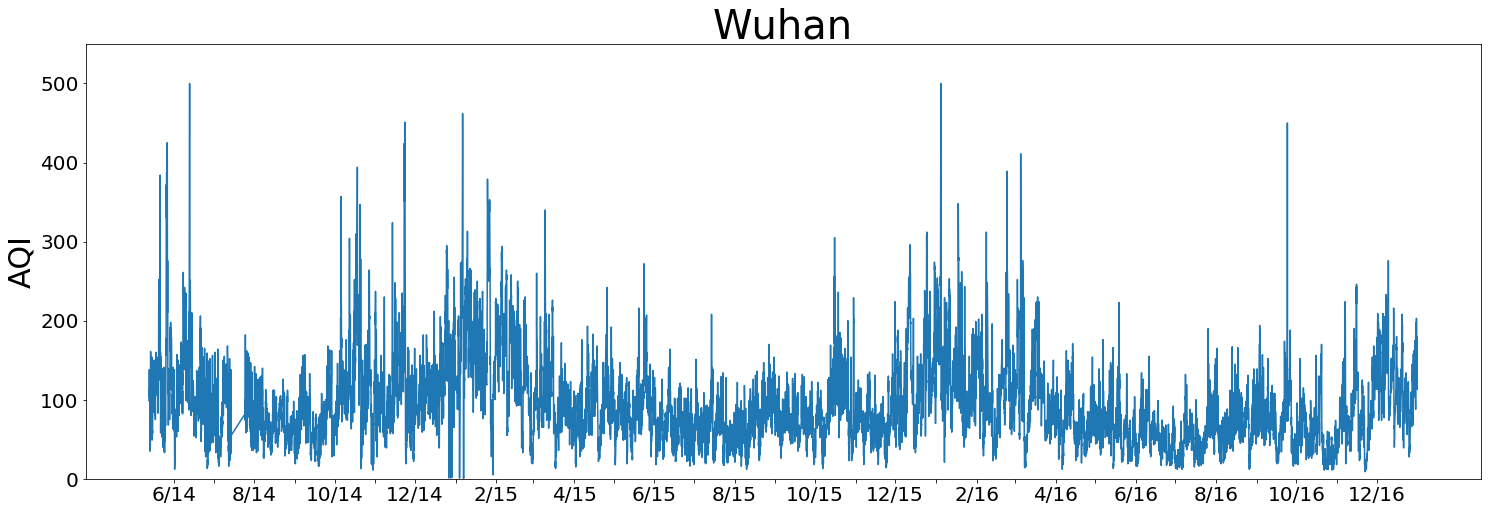

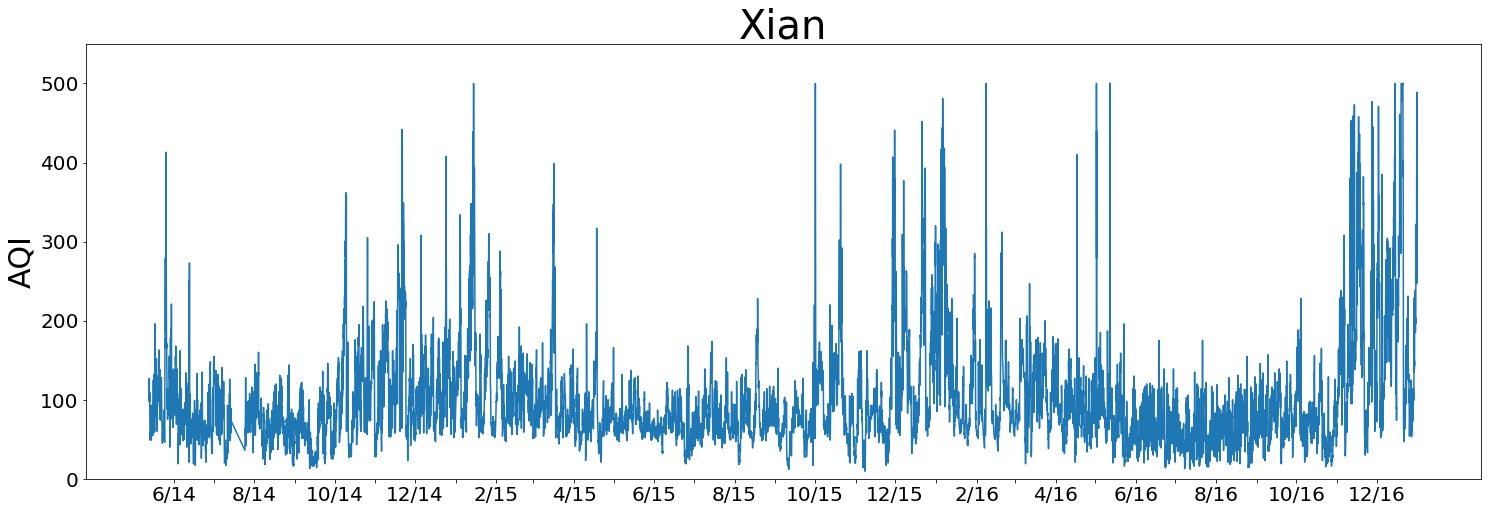

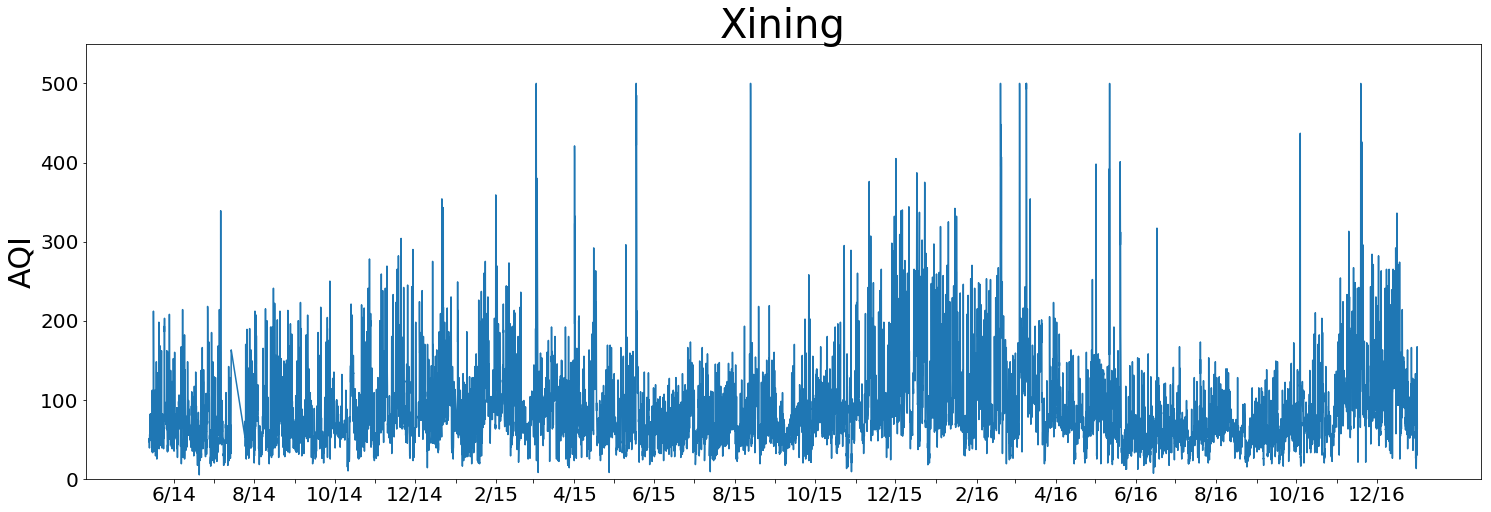

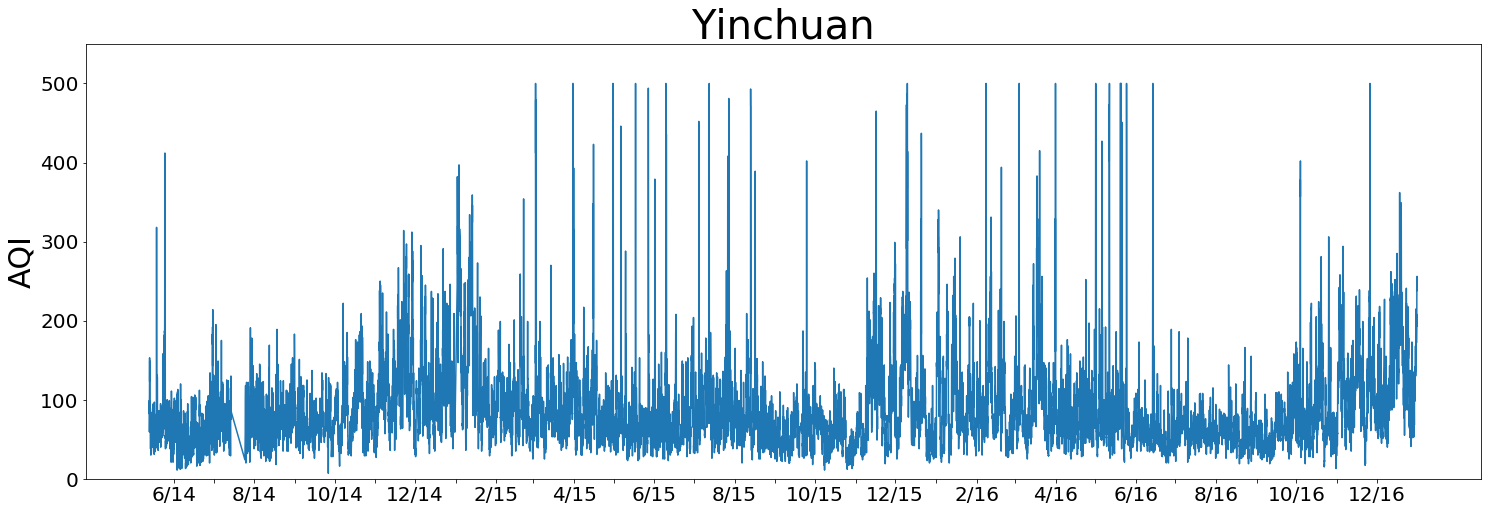

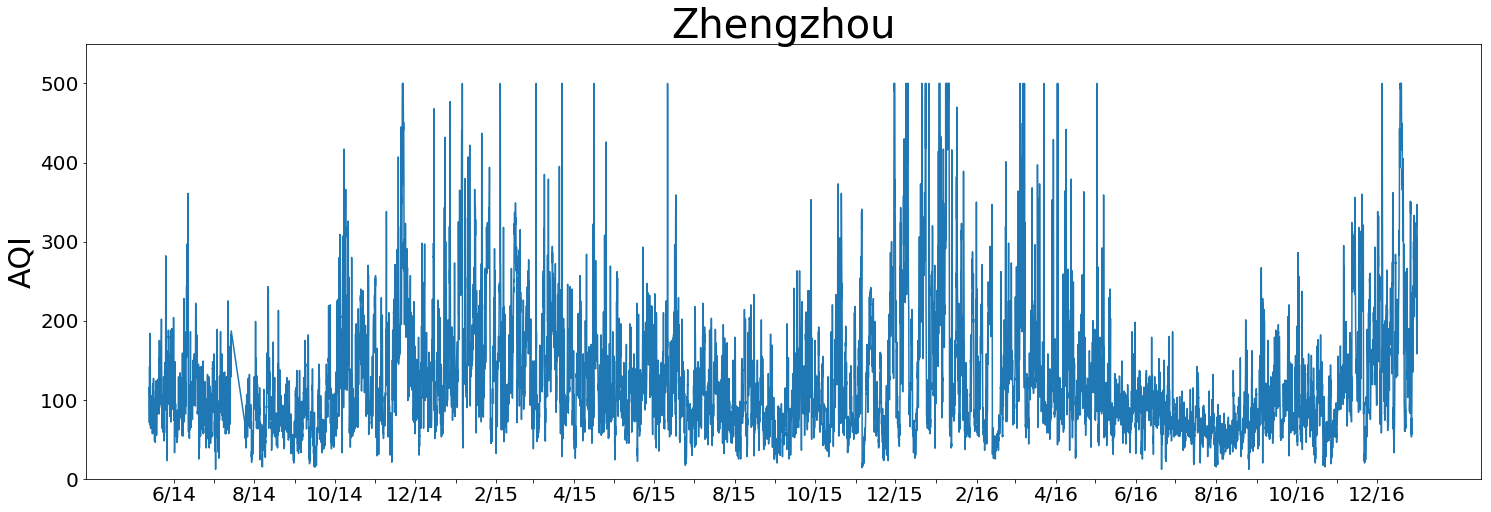

In [9]:
labels = ['6/14', '', '8/14', '', '10/14', '', '12/14', '', '2/15','','4/15','','6/15','','8/15',
          '','10/15','','12/15','','2/16','','4/16','','6/16','','8/16','','10/16','','12/16']

for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    stationID = stations_to_use[m]
    name = metros_to_use[m]
    plt.plot(AQI_less[stationID])
    plt.ylim(0, 550)
    plt.ylabel('AQI', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


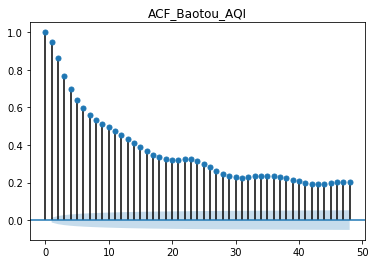

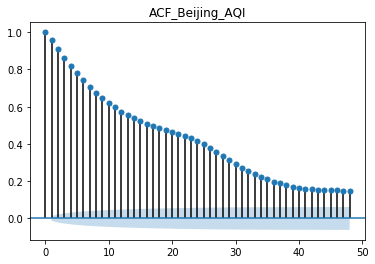

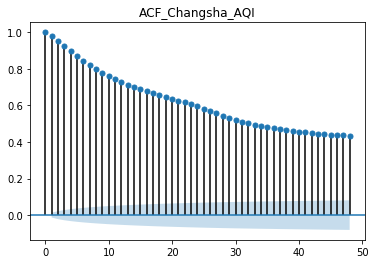

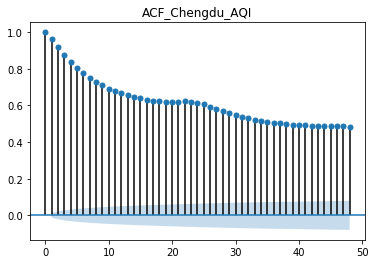

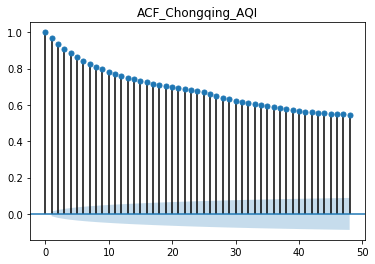

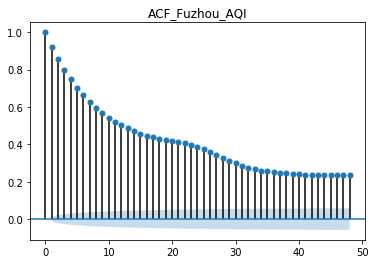

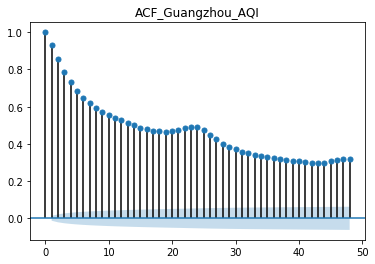

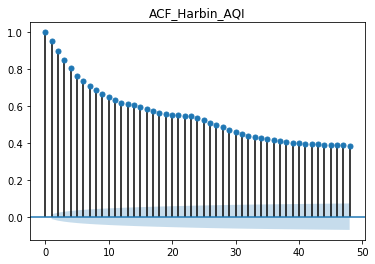

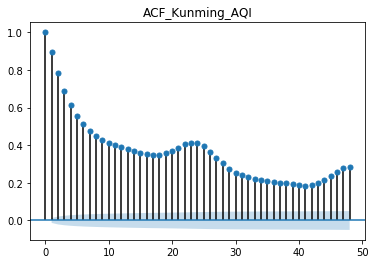

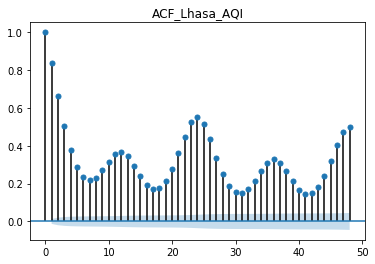

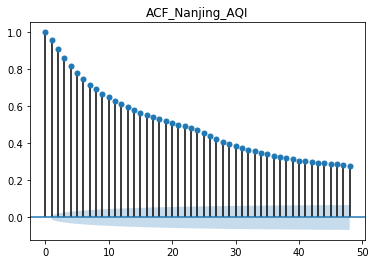

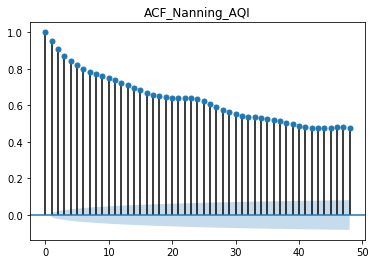

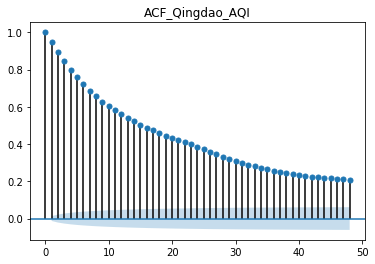

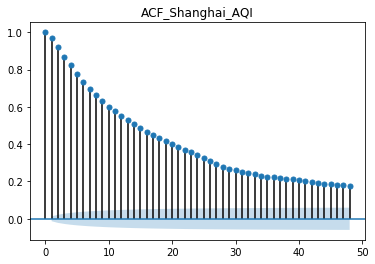

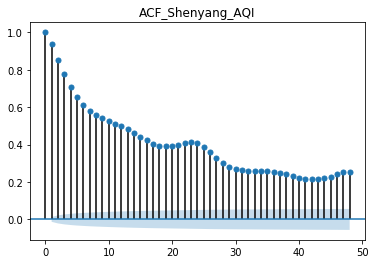

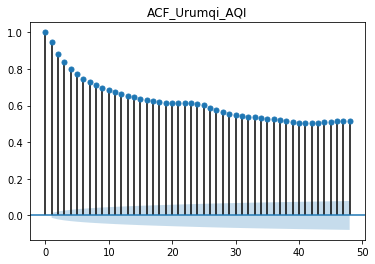

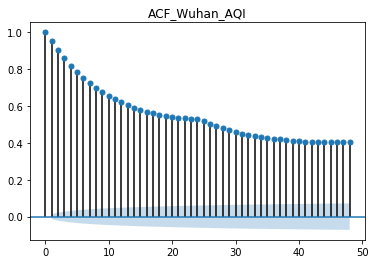

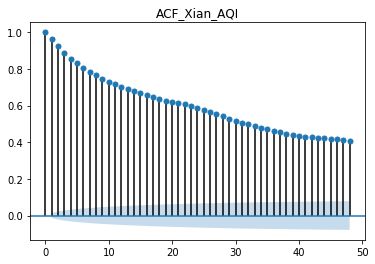

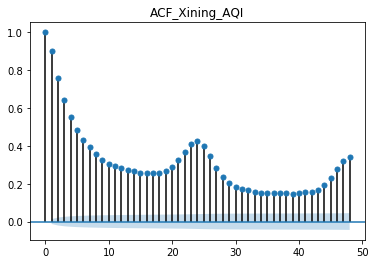

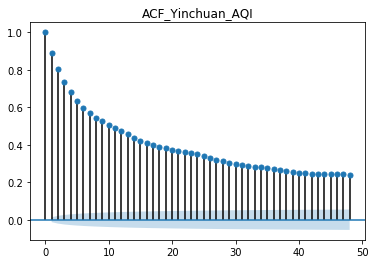

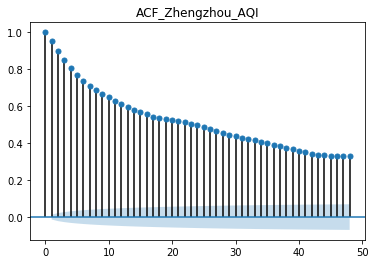

In [19]:
for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    stationID = stations_to_use[m]
    name = metros_to_use[m]
    plot_acf(x=AQI_less[stationID], lags=48, title="ACF_"+name+'_AQI')

### What's up with Lhasa?  

In [11]:
metros_to_use[9]

'Lhasa'

In [12]:
stations_to_use[9]

'1456A'

In [13]:
arrs = pd.DataFrame(index=np.arange(24))
for h in range(24):
    hourDF = AQI_less[AQI_less['hour']==h].reset_index(drop=True)
    arr = hourDF[['1456A']].rename(columns={'1456A':'hour'+str(h)})
    arrs = arrs.merge(arr, right_index=True, left_index=True)
arrs.head()

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,66.0,75.0,70.0,44.0,43.0,44.0,41.0,35.0,54.0,68.0,...,44.0,46.0,37.5,29.0,80.0,84.0,62.0,100.0,73.0,67.0
1,82.0,88.0,83.0,64.0,90.0,67.0,46.0,73.0,75.0,124.0,...,82.0,57.0,81.0,85.0,135.0,68.0,50.0,45.0,53.0,57.0
2,44.0,57.0,70.0,55.0,52.0,42.0,41.0,39.0,58.0,72.0,...,49.0,54.0,57.0,60.0,55.0,58.0,49.0,46.0,49.0,60.0
3,56.0,50.0,51.0,46.5,42.0,44.0,45.0,44.0,50.0,61.0,...,45.0,46.0,46.0,47.0,47.0,48.0,45.0,40.0,47.0,63.0
4,66.0,68.0,57.0,54.0,55.0,50.0,50.0,48.0,102.0,89.0,...,114.0,115.0,112.0,138.0,138.0,115.0,98.0,82.0,117.0,98.0


In [14]:
for x in range(12):
    correlation = arrs['hour'+str(x)].corr(arrs['hour'+str(x+12)])
    print(x, x+12, round(correlation,3))

0 12 -0.291
1 13 -0.369
2 14 -0.157
3 15 0.036
4 16 0.303
5 17 0.163
6 18 0.085
7 19 0.285
8 20 0.55
9 21 0.102
10 22 0.046
11 23 0.349


In [15]:
for x in range(24):
     print (x, round(acf(arrs['hour'+str(x)])[1],3))

0 0.296
1 0.196
2 0.177
3 0.24
4 0.236
5 0.207
6 0.468
7 0.142
8 0.261
9 0.084
10 -0.004
11 -0.003
12 0.088
13 -0.036
14 0.157
15 0.185
16 -0.008
17 0.01
18 0.066
19 0.215
20 0.113
21 0.074
22 0.073
23 0.238


Strong negative correlation at t-12 between 12AM and 12PM. Doesn't really make sense. 
Positive correlation at t-24 for night hours; no correlation at t-24 for regular daytime hours.